# Bring Packages

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

# Load Data

In [6]:
# Load and display data
print("Loading training data...")
X_train = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/data_train.npy").astype(int)
print("Training data loaded.")

print("Loading training labels...")
y_train = np.loadtxt('D:/GitHub/Classer-le-text---Text-classification/Data/label_train.csv', skiprows=1, delimiter=',').astype(int)[:, 1]
print("Training labels loaded.")

print("Loading test data...")
X_test = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/data_test.npy").astype(int)
print("Test data loaded.")

print("Loading vocabulary...")
vocab_data = np.load("D:/GitHub/Classer-le-text---Text-classification/Data/vocab_map.npy", allow_pickle=True)
print("Vocab data loaded.")

# Check dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocab data shape: {vocab_data.shape}")

Loading training data...
Training data loaded.
Loading training labels...
Training labels loaded.
Loading test data...
Test data loaded.
Loading vocabulary...
Vocab data loaded.
Training data shape: (9422, 26354)
Training labels shape: (9422,)
Test data shape: (2356, 26354)
Vocab data shape: (26354,)


In [7]:
vocab_data.shape

(26354,)

In [8]:
x_raw = X_train
y_raw = y_train

In [9]:
def testdf(df):
    if isinstance(df, pd.DataFrame):
        print("The object is a DataFrame.")
    else:
        print("The object is not a DataFrame.")

def test_if_list(obj):
    if isinstance(obj, list):
        print("The object is a list.")
    else:
        print("The object is not a list.")

def test_if_tuple(obj):
    if isinstance(obj, tuple):
        print("The object is a tuple.")
    else:
        print("The object is not a tuple.")

def test_if_array(obj):
    if isinstance(obj, np.ndarray):
        print("The object is a numpy array.")
    else:
        print("The object is not a numpy array.")

# Model

In [10]:
print(y_train)
print(y_raw)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


# Data Visualization

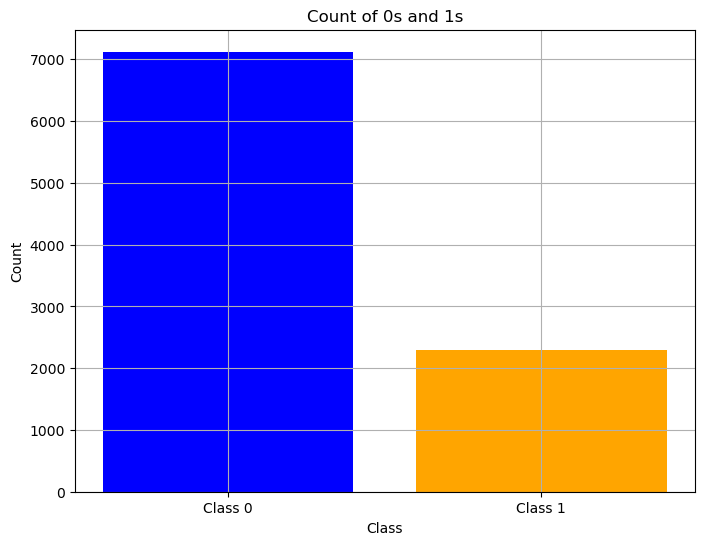

In [11]:
# Extract the class labels from the second column of y_train
class_labels = y_raw

# Count the occurrences of class 0 and class 1
unique, counts = np.unique(class_labels, return_counts=True)
count_dict = dict(zip(unique, counts))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(count_dict.keys(), count_dict.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of 0s and 1s')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)
plt.show()

In [12]:
# Calculate the difference and ratio of counts
count_diff = abs(count_dict[0] - count_dict[1])
count_ratio = count_dict[0] / count_dict[1] if count_dict[1] != 0 else float('inf')

# Print the results
print(f"Difference in counts: {count_diff}")
print(f"Ratio of counts: {count_ratio:.2f}")

Difference in counts: 4826
Ratio of counts: 3.10


In [13]:
def print_class_percentages(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    percentages = {cls: (count / total) * 100 for cls, count in zip(unique, counts)}
    
    print(f"Class percentages for {dataset_name}:")
    for cls, percentage in percentages.items():
        print(f"Class {cls}: {percentage:.2f}%")

# Print class percentages for training and test datasets
print_class_percentages(class_labels, "Training Dataset")


Class percentages for Training Dataset:
Class 0: 75.61%
Class 1: 24.39%


In [14]:
print(unique, counts)

[0 1] [7124 2298]


## See on average how often does a word appear in text

In [15]:
## See on average how often does a word appear in text

In [16]:
ind_class0 = (y_raw==1).nonzero()[0]
print(ind_class0)
ind_class1 = (y_raw==0).nonzero()[0]
print(ind_class1)

[   4    8    9 ... 9410 9412 9418]
[   0    1    2 ... 9419 9420 9421]


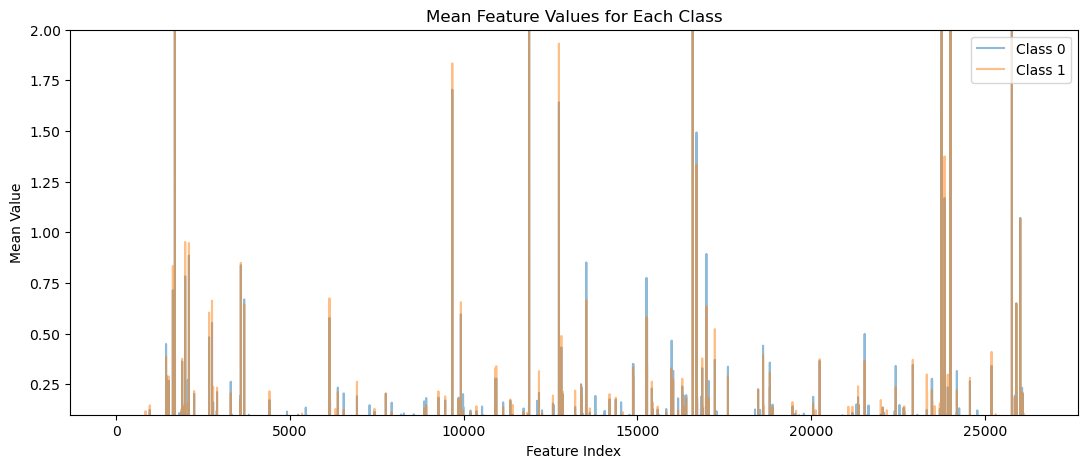

In [17]:
plt.figure(figsize=(13, 5))

# Plot the mean values for each class
plt.plot(X_train[ind_class0, :].mean(axis=0), alpha=0.5, label="Class 0")
plt.plot(X_train[ind_class1, :].mean(axis=0), alpha=0.5, label="Class 1")

# Add titles and labels
plt.title("Mean Feature Values for Each Class")
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.legend()  # Add legend for class labels
plt.ylim(0.1, 2)  # Adjust y-axis limit if needed
plt.show()

In [18]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = x_raw[y_raw == 0].mean(axis=0)
mean_appearance_class_1 = x_raw[y_raw == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'and', 'we', 'in', 'to', 'is', 'our', 'that', 'models', 'this', 'model', 'learning', 'neural', 'system', 'are', 'on', 'paper', 'show', 'for', 'based', 'used', 'systems', 'an', 'art', 'be', 'matrix', 'convex', 'information', 'tasks']


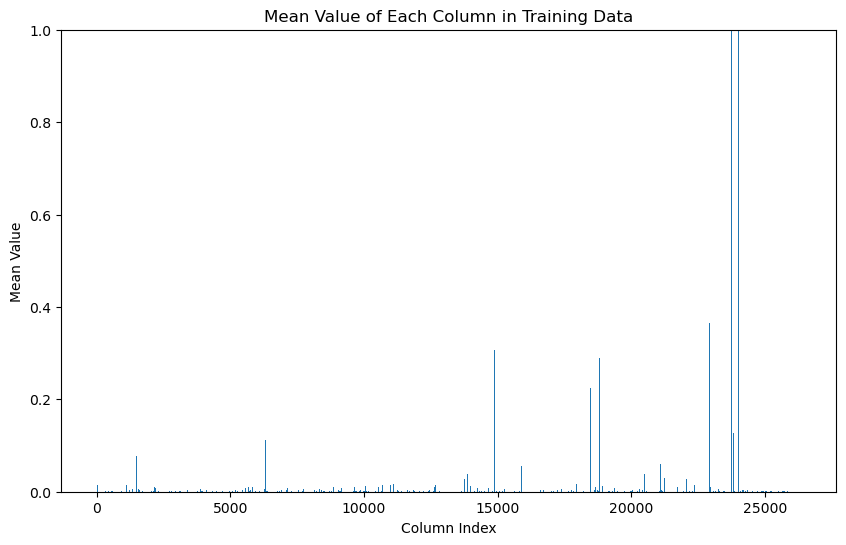

In [19]:
column_means = np.mean(x_raw, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [20]:
column_means

array([0.00021227, 0.00870304, 0.00010613, ..., 0.00021227, 0.00021227,
       0.00159202])

## Identify the means of appearance of words when class 1 vs when class 0 and finding the words with the largest difference of appearances

In [21]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = X_train[y_train == 0].mean(axis=0)
mean_appearance_class_1 = X_train[y_train == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'and', 'we', 'in', 'to', 'is', 'our', 'that', 'models', 'this', 'model', 'learning', 'neural', 'system', 'are', 'on', 'paper', 'show', 'for', 'based', 'used', 'systems', 'an', 'art', 'be', 'matrix', 'convex', 'information', 'tasks']


In [22]:
mean_difference

array([0.00029479, 0.00345295, 0.00014037, ..., 0.00028074, 0.00028074,
       0.00210556])

In [23]:
#Remove the useless data
# Calculate the mean of each column
column_means = X_train.mean(axis=0)

# Identify columns where the mean is zero
columns_to_drop = np.where(column_means == 0)[0]

# Drop these columns from the dataset
X_train_zero_dropped = np.delete(X_train, columns_to_drop, axis=1)



In [24]:
#log transform the data

x_log = np.log(X_train_zero_dropped+1)

In [25]:
x_raw.shape

(9422, 26354)

In [26]:
y_raw.shape

(9422,)

In [27]:
len(column_means)

26354

In [28]:
column_means = np.mean(x_log, axis=0)
means = np.mean(x_log, axis=1)
std = column_means.std()
means


array([0.00206832, 0.00306722, 0.00169472, ..., 0.00302432, 0.00240641,
       0.00689419])

In [29]:
np.mean(column_means)

0.0028786594107875012

In [30]:
np.std(column_means)

0.028791129617707568

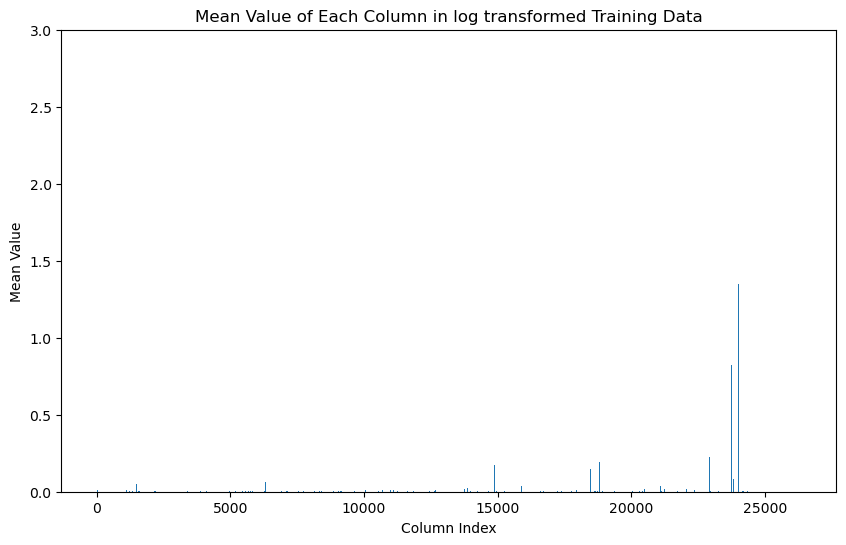

In [31]:
column_means = np.mean(x_log, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 3)
plt.title('Mean Value of Each Column in log transformed Training Data')
plt.show()

In [32]:
# Calculate column means
column_means = np.mean(x_log, axis=0)

# Define the desired percentiles
percentiles = [10, 25, 50, 75, 90, 100]

# Calculate the percentile values for column means
percentile_values = np.percentile(column_means, percentiles)

# Display the results
for p, value in zip(percentiles, percentile_values):
    print(f"{p}th percentile: {value}")

10th percentile: 7.356688394820052e-05
25th percentile: 7.356688394820052e-05
50th percentile: 0.00014713376789640104
75th percentile: 0.0006010359244466085
90th percentile: 0.0032619445994428314
100th percentile: 2.0028919921011603


In [33]:
column_means

array([1.47133768e-04, 5.26640240e-03, 7.35668839e-05, ...,
       1.16600752e-04, 1.16600752e-04, 5.31801666e-04])

In [34]:
# Set a minimum absolute correlation threshold
threshold = 0.0032619445994428314

# Compute the absolute values of the means
mean_remove_indices = np.where(np.abs(column_means) < threshold)[0]

print("Indices of features to remove:", mean_remove_indices)

Indices of features to remove: [    0     2     3 ... 26351 26352 26353]


## Variance 

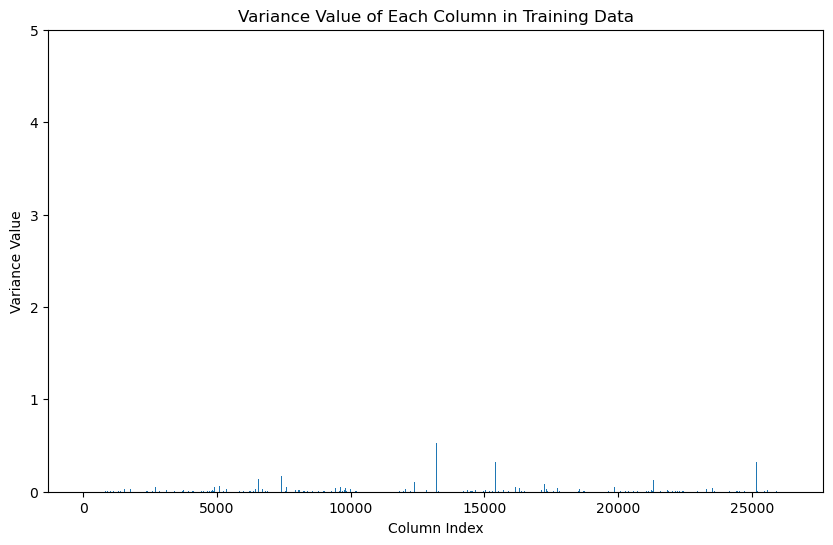

In [35]:
column_var = np.var(x_raw, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_var)), column_var)
plt.xlabel('Column Index')
plt.ylabel('Variance Value')
plt.ylim(0, 1)
plt.title('Variance Value of Each Column in Training Data')
plt.show()

In [36]:
print(np.min(column_var),np.max(column_var))

0.0001061233140968924 24.006902960553276


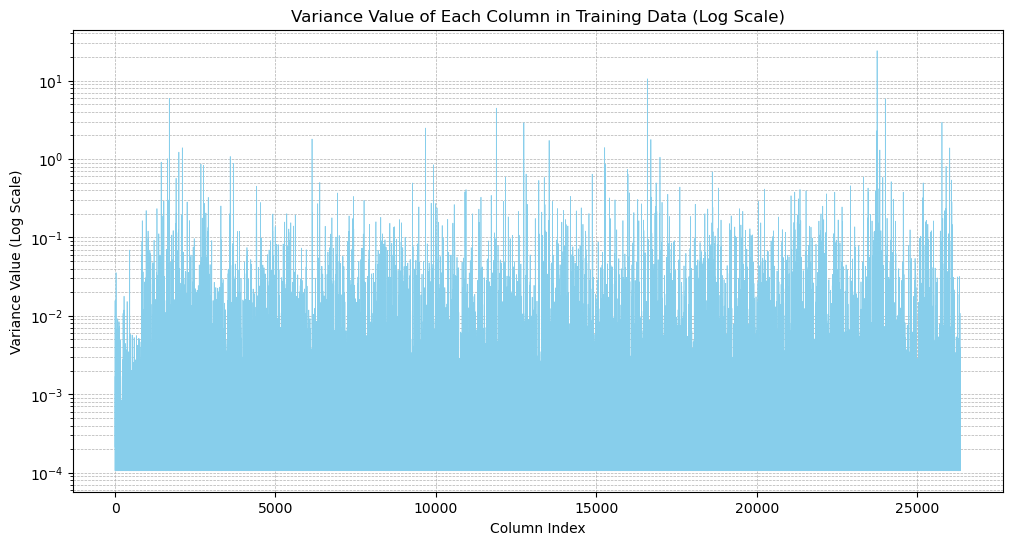

In [37]:
# Plotting with a logarithmic scale on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(column_var, color='skyblue', linestyle='-', linewidth=0.5)
plt.yscale('log')
plt.title("Variance Value of Each Column in Training Data (Log Scale)")
plt.xlabel("Column Index")
plt.ylabel("Variance Value (Log Scale)")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()



## Corelation analysis

In [38]:
# Calculate point-biserial correlation for each feature with the target
correlations = []
for i in range(X_train.shape[1]):
    corr, _ = pointbiserialr(X_train[:, i], y_train)
    correlations.append(corr)

# Convert to DataFrame for easy plotting
correlation_df = pd.DataFrame({
    'Feature': range(X_train.shape[1]),
    'Correlation': correlations
})



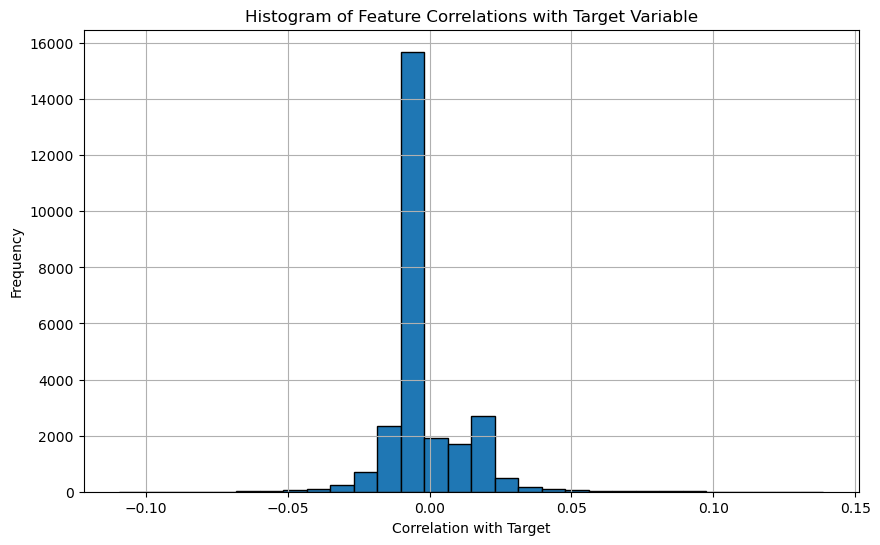

In [39]:
# Assuming `correlation_df` contains a column 'Correlation' with correlation values
plt.figure(figsize=(10, 6))
plt.hist(correlation_df['Correlation'], bins=30, edgecolor='k')
plt.title('Histogram of Feature Correlations with Target Variable')
plt.xlabel('Correlation with Target')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

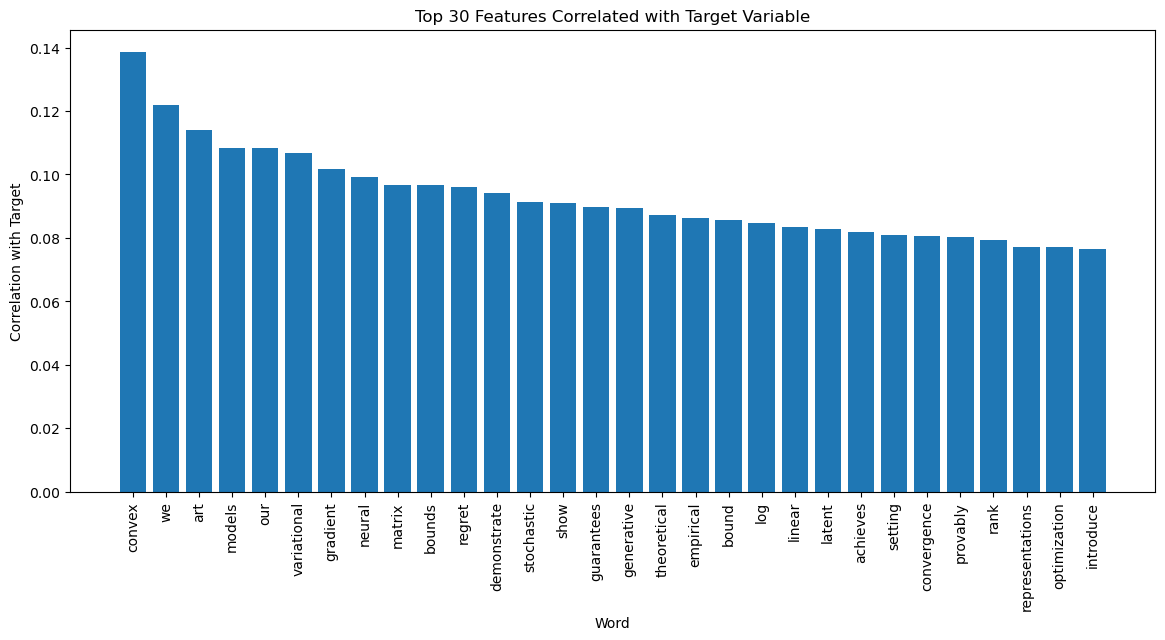

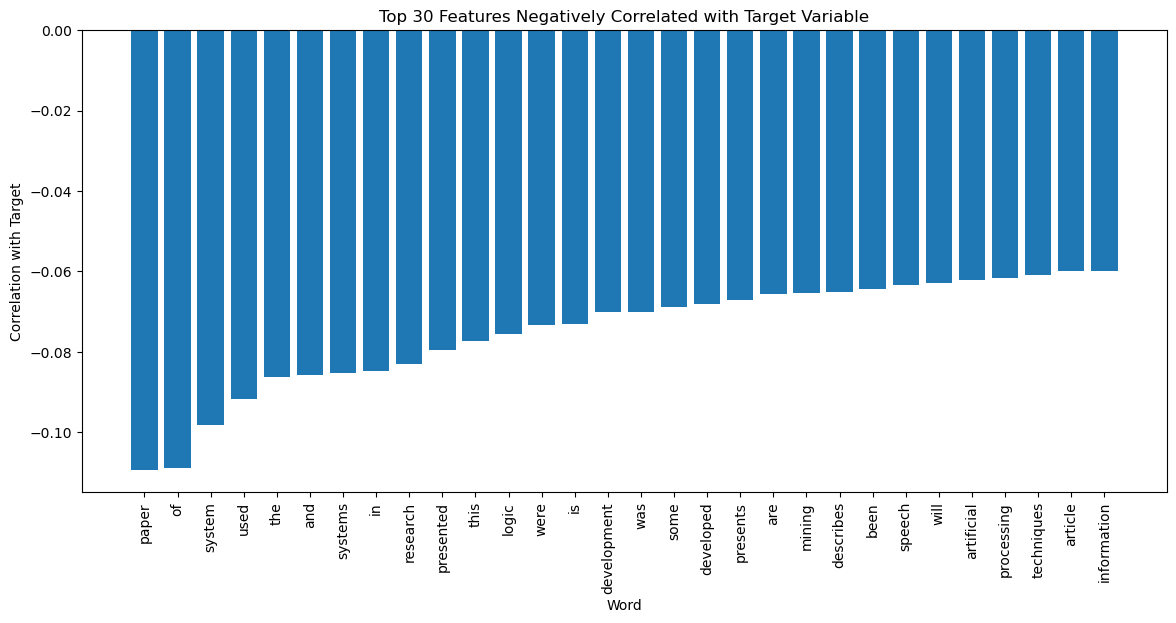

In [40]:
# Get the indices and values for the top 30 and smallest 30 correlations
top_30_indices = np.argsort(correlations)[-30:][::-1]
top_30_values = [correlations[i] for i in top_30_indices]
smallest_30_indices = np.argsort(correlations)[:30]
smallest_30_values = [correlations[i] for i in smallest_30_indices]

# Map feature indices to words
top_30_words = [vocab_data[i] for i in top_30_indices]
smallest_30_words = [vocab_data[i] for i in smallest_30_indices]

# Plot the top 30 correlations
plt.figure(figsize=(14, 6))
plt.bar(top_30_words, top_30_values)
plt.title('Top 30 Features Correlated with Target Variable')
plt.xlabel('Word')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=90)
plt.show()

# Plot the smallest 30 correlations
plt.figure(figsize=(14, 6))
plt.bar(smallest_30_words, smallest_30_values)
plt.title('Top 30 Features Negatively Correlated with Target Variable')
plt.xlabel('Word')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=90)
plt.show()

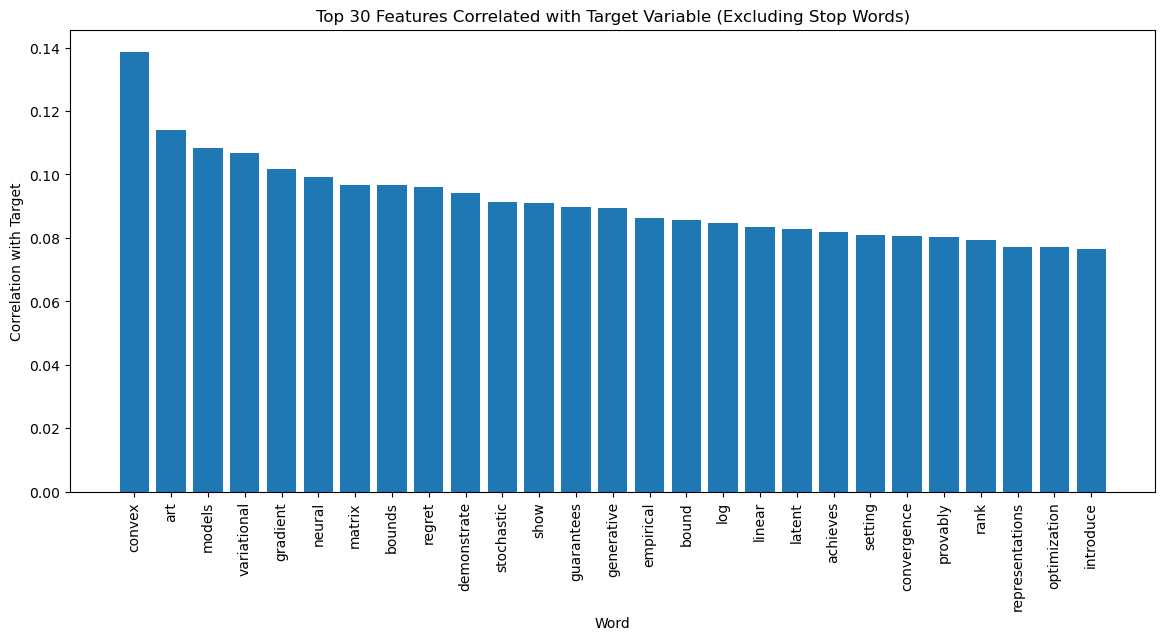

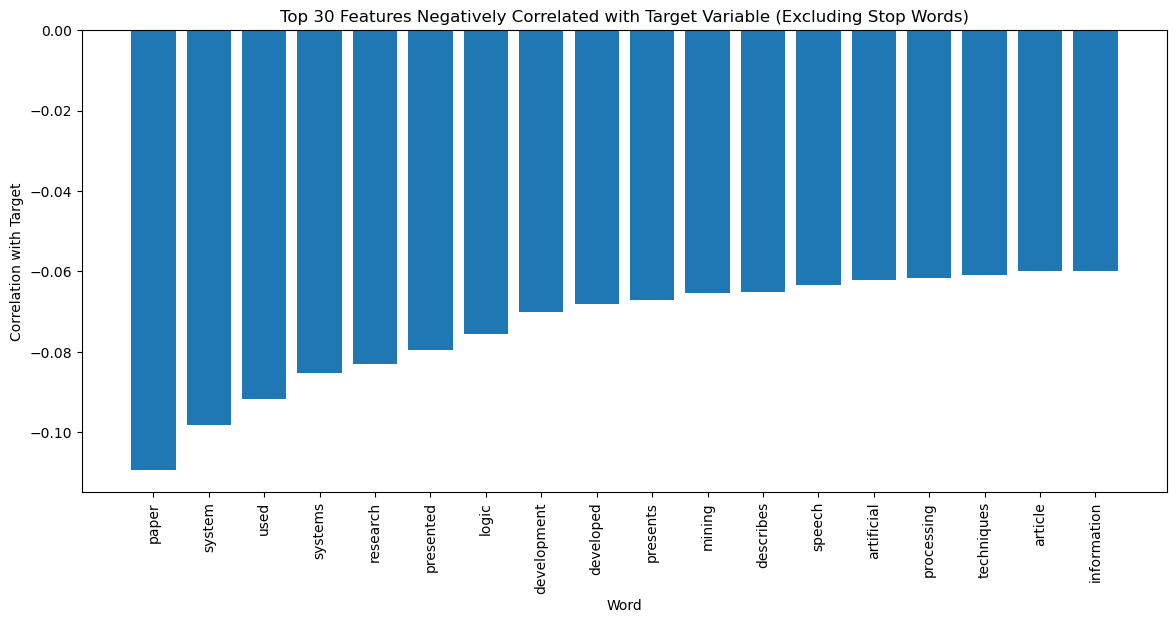

In [43]:
# Get indices and values for the top 30 correlations, excluding stop words
top_30_indices = [i for i in np.argsort(correlations)[-30:][::-1] if i not in stop_word_indices]
top_30_values = [correlations[i] for i in top_30_indices[:30]]  # Limit to 30 values after filtering
top_30_words = [vocab_data[i] for i in top_30_indices[:30]]

# Get indices and values for the smallest 30 correlations, excluding stop words
smallest_30_indices = [i for i in np.argsort(correlations)[:30] if i not in stop_word_indices]
smallest_30_values = [correlations[i] for i in smallest_30_indices[:30]]  # Limit to 30 values after filtering
smallest_30_words = [vocab_data[i] for i in smallest_30_indices[:30]]

# Plot the top 30 correlations
plt.figure(figsize=(14, 6))
plt.bar(top_30_words, top_30_values)
plt.title('Top 30 Features Correlated with Target Variable (Excluding Stop Words)')
plt.xlabel('Word')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=90)
plt.show()

# Plot the smallest 30 correlations
plt.figure(figsize=(14, 6))
plt.bar(smallest_30_words, smallest_30_values)
plt.title('Top 30 Features Negatively Correlated with Target Variable (Excluding Stop Words)')
plt.xlabel('Word')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=90)
plt.show()

In [44]:
print(top_30_words,smallest_30_words)

['convex', 'art', 'models', 'variational', 'gradient', 'neural', 'matrix', 'bounds', 'regret', 'demonstrate', 'stochastic', 'show', 'guarantees', 'generative', 'empirical', 'bound', 'log', 'linear', 'latent', 'achieves', 'setting', 'convergence', 'provably', 'rank', 'representations', 'optimization', 'introduce'] ['paper', 'system', 'used', 'systems', 'research', 'presented', 'logic', 'development', 'developed', 'presents', 'mining', 'describes', 'speech', 'artificial', 'processing', 'techniques', 'article', 'information']


In [45]:
# Separate positive and negative correlations
positive_correlations = correlation_df[correlation_df['Correlation'] > 0]['Correlation']
negative_correlations = correlation_df[correlation_df['Correlation'] < 0]['Correlation']

# Define the desired percentiles
percentiles = [10, 25, 50, 75, 90, 100]

# Calculate percentiles for positive correlations
positive_percentile_values = np.percentile(positive_correlations, percentiles)
print("Percentiles for Positive Correlations:")
for p, value in zip(percentiles, positive_percentile_values):
    print(f"{p}th percentile: {value}")

# Calculate percentiles for negative correlations
negative_percentile_values = np.percentile(negative_correlations, percentiles)
print("\nPercentiles for Negative Correlations:")
for p, value in zip(percentiles, negative_percentile_values):
    print(f"{p}th percentile: {value}")

Percentiles for Positive Correlations:
10th percentile: 0.002562134910361488
25th percentile: 0.007117641824045423
50th percentile: 0.015918743437536347
75th percentile: 0.01814004839343493
90th percentile: 0.02565526409606653
100th percentile: 0.13875091050030058

Percentiles for Negative Correlations:
10th percentile: -0.014187568643145168
25th percentile: -0.008275659305554652
50th percentile: -0.005851464234715492
75th percentile: -0.00585146423471544
90th percentile: -0.0058514642347154075
100th percentile: -4.500404280299375e-05


In [46]:
# Set a minimum absolute correlation threshold
lower_threshold = -0.0058514642347154075
upper_threshold = 0.02565526409606653

# Assume correlation_df has the correlation values for each feature
# Create an index of features to remove based on the threshold
correlation_remove_indices = correlation_df[(correlation_df['Correlation'] < upper_threshold) & (correlation_df['Correlation'] > lower_threshold)].index.tolist()


print("Indices of features to remove:", mean_remove_indices)

Indices of features to remove: [    0     2     3 ... 26351 26352 26353]


## Stop words removal

In [47]:
# Define a list of stop words
stop_words = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'while', 'with', 'without', 'of', 'at', 'by', 'for', 'to', 'in', 'on', 'from', 'up', 'down', 'out', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now','we', 'our', 'theoretical', 'of', 'the', 'and', 'in', 'this', 'were', 'is', 'was', 'some', 'are', 'been', 'will']

# Identify the indices of the stop words in the vocabulary
stop_word_indices = [i for i, word in enumerate(vocab_data) if word in stop_words]

print(stop_word_indices)

[1293, 1466, 1634, 1691, 1811, 1989, 2246, 2791, 3299, 3571, 3590, 3686, 7452, 7487, 7761, 9341, 9674, 9921, 10008, 11072, 11341, 11639, 11884, 12742, 13002, 15415, 15442, 16141, 16262, 16291, 16335, 16591, 16701, 16703, 16717, 16865, 16972, 16985, 16991, 17049, 17136, 20791, 21536, 21929, 22003, 22924, 23744, 23753, 23774, 23783, 23796, 23838, 24009, 24051, 24780, 25114, 25415, 25723, 25774, 25868, 25891, 25894, 25911, 25926, 25974, 26016, 26021]


## Gathering all indices to remove as a mask

In [48]:
# Convert both indices to lists if they are not already
stop_word_indices = list(stop_word_indices)
mean_remove_indices = list(mean_remove_indices)

# Combine the two lists of indices into a single set of unique indices
all_remove_indices = set(stop_word_indices + mean_remove_indices)

# Create a mask for the features in the train set
mask = np.array([i not in all_remove_indices for i in range(X_train.shape[1])])

In [49]:
# Apply the mask to filter columns in X_train
X_train_masked = X_train[:, mask]
X_test_masked = X_test[:, mask]

## Log Transform

In [50]:
X_log = np.log(X_train_masked + 1)
X_test_log = np.log(X_test_masked + 1)

## Smote resampling

In [51]:
# Apply SMOTE to balance the dataset
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_log, y_raw)

# Test which model fits best for the data

In [52]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),


    'Random Forest': RandomForestClassifier(random_state=42)
}

In [53]:
# Train models and evaluate using cross-validation
best_model = None
best_score = 0
for model_name, model in models.items():
    print(f"Training {model_name}...")
    cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring=make_scorer(f1_score, average='weighted'))
    mean_cv_score = np.mean(cv_scores)
    print(f"{model_name} F1 scores: {cv_scores}")
    print(f"{model_name} Mean F1 score: {mean_cv_score}")
    if mean_cv_score > best_score:
        best_score = mean_cv_score
        best_model = model

Training Logistic Regression...
Logistic Regression F1 scores: [0.73213128 0.79099584 0.87103591 0.88151347 0.87703625]
Logistic Regression Mean F1 score: 0.8305425529294986
Training Naive Bayes...
Naive Bayes F1 scores: [0.75508724 0.78385284 0.81880966 0.82819489 0.81557057]
Naive Bayes Mean F1 score: 0.8003030394581309
Training Random Forest...
Random Forest F1 scores: [0.3563076  0.68234746 0.98631323 0.98630849 0.98490347]
Random Forest Mean F1 score: 0.7992360487772221


In [60]:
print(best_model)

LogisticRegression(max_iter=1000, random_state=42)


In [54]:
# Train the best model on the entire resampled dataset
best_model.fit(X_resampled, y_resampled)

# Predict on the test data
y_test_pred = best_model.predict(X_test_log)

# Print the predictions
print(f"Predictions on test data: {y_test_pred}")

Predictions on test data: [0 0 1 ... 0 0 0]


In [55]:
print(np.unique(y_test_pred))

[0 1]


# Download results

In [56]:
import pandas as pd
import os as os

In [57]:
def save_array_with_index(array, filename):
    # Create a DataFrame with the array
    df = pd.DataFrame(array, columns=['label'])
    
    # Add the 'id' column using the row index
    df['ID'] = df.index
    
    # Reorder the columns to have 'id' first and 'label' second
    df = df[['ID', 'label']]
    
    # Check if the file exists and save over it
    if os.path.exists(filename):
        print(f"File {filename} exists. Saving over it.")
    else:
        print(f"File {filename} does not exist. Creating a new file.")
    
    # Save the DataFrame as a CSV file
    print("Saving")
    df.to_csv(filename, index=False)
    print("Saved")

In [ ]:
filename = 'prediction_milestone2.csv'

#save_array_with_index(y_test_pred, filename)

# Testing XGBoost

In [56]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import mutual_info_classif, RFE,SelectKBest, f_classif
import xgboost as xgb
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt


import os

In [57]:
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'scale_pos_weight': [1, 5, 10]  # Adjust based on class imbalance
}


In [59]:
# Initialize the model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='f1',  # Scoring metric to optimize
    cv=5,  # Number of cross-validation folds
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the data
random_search.fit(X_resampled, y_resampled)

# Output the best parameters and the best F1 score
print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 5, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best F1 Score: 0.7838962273080542


In [ ]:
final_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    scale_pos_weight=1,  # Best parameter from tuning
    subsample=0.8,       # Best parameter from tuning
    n_estimators=50,     # Best parameter from tuning
    min_child_weight=1,  # Best parameter from tuning
    max_depth=7,         # Best parameter from tuning
    learning_rate=0.1,   # Best parameter from tuning
    gamma=0.5,           # Best parameter from tuning
    colsample_bytree=0.6, # Best parameter from tuning
    random_state=42,  
)

In [ ]:
# Initialize cross-validation metrics storage
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_precision = []
cross_val_recall = []
cross_val_f1 = []
conf_matrices = []


In [ ]:
# Loop over each fold of resampled data
for train_index, val_index in kf.split(X_train_final, y_train_resampled):
    # Split resampled data into training and validation for the current fold
    X_train_fold, X_val_fold = X_train_final[train_index], X_train_final[val_index]
    y_train_fold, y_val_fold = y_train_resampled[train_index], y_train_resampled[val_index]
    
    # Train the model on the current fold
    final_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_val_pred = final_model.predict(X_val_fold)
    
    # Calculate metrics for the validation fold
    precision = precision_score(y_val_fold, y_val_pred, zero_division=0)
    recall = recall_score(y_val_fold, y_val_pred, zero_division=0)
    f1 = f1_score(y_val_fold, y_val_pred, zero_division=0)
    
    # Store metrics for averaging later
    cross_val_precision.append(precision)
    cross_val_recall.append(recall)
    cross_val_f1.append(f1)
    
    # Store confusion matrix for the validation fold
    conf_matrices.append(confusion_matrix(y_val_fold, y_val_pred))

# Calculate and display average cross-validation scores
avg_precision = np.mean(cross_val_precision)
avg_recall = np.mean(cross_val_recall)
avg_f1 = np.mean(cross_val_f1)

print(f"Cross-Validation Precision: {avg_precision:.4f}")
print(f"Cross-Validation Recall: {avg_recall:.4f}")
print(f"Cross-Validation F1 Score: {avg_f1:.4f}")

# Optional: display confusion matrices for each fold
for i, cm in enumerate(conf_matrices):
    print(f"Confusion Matrix for Fold {i + 1}:\n{cm}\n")

In [ ]:


# Predict on the test data
y_test_pred = final_model.predict(X_test_final)
print("Predictions on test data:")
print(y_test_pred)
print(y_test_pred[:10])  # Print the first 10 predictions